##  Análise   Regressivo Simbólica da Solução do Poço quadrado de Potencial Infinito 

## Pela via Clássica 

In [1]:
#Bibliotecas Gerais
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh 

In [2]:
#Constantes físicas
hbar = 1.,0   #Constante de Planck reduzida
m = 1.0       #Massa da partícula
#Parâmetros do poitencial infinito
a=1.0         #Largura do poço
V0 = 10.0     #Profundidade do poço

In [3]:
#Função que calcula o potencial
def potencial(x):
    potencial = np.zeros_like(x)
    potencial[(x< -a/2) | (x>a/2)] = V0
    return potencial
#Função para, numericamente resolver a eqS
def solve_schrodinger(N,L,V_func):
    """
    N - quantidade de acrescimos em x
    L - largura do potencial
    V_f - função Potencial
    """
     #1. Definir grade e potencial
    x = np.linspace(-L/2, L/2, N)
    dx = x[1] - x[0]
    V = V_func(x)
    #2. Construir a matriz hamiltoniana
    #Termo cinético
    main_diag = 1/(m*dx**2) * np.ones(N)
    off_diag = -1/(2*m*dx**2) * np.ones(N-1)
    H = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
    #Termo potencial
    H += np.diag(V)
    #3. Diagonalizar a matriz hamiltoniana
    energia, psi = eigh(H)  # diagonaliza a matriz e calcula autovalores (energia) e autovetores (psi)
    #Normalizar as funções de onda
    for i in range(psi.shape[1]):
        psi[:,i] /= np.sqrt(np.sum(psi[:,i]**2) * dx) 
    return x, energia, psi    



In [4]:
# Parâmetros da simulação
N = 200  # Número de pontos na grade
L = 10.0 # Comprimento da caixa

# Resolver a equação de Schrödinger
x, energia, psi = solve_schrodinger(N, L, potencial)
y=psi[:,1]

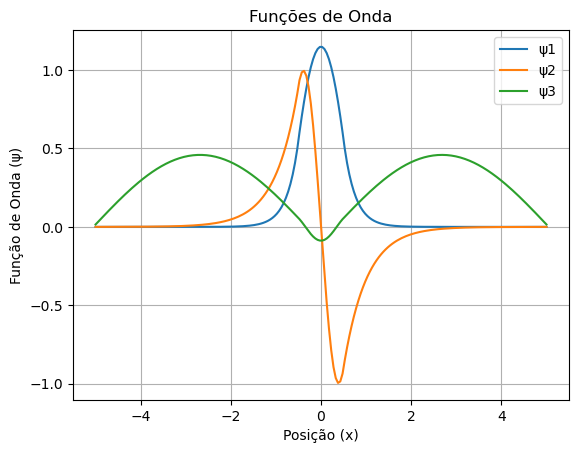

In [5]:
for i in range(min(3, psi.shape[1])):  # Plota até o número de funções de onda encontradas
    plt.plot(x, psi[:, i], label=f"ψ{i+1}")
    plt.title("Funções de Onda")
    plt.xlabel("Posição (x)")
    plt.ylabel("Função de Onda (ψ)")
    plt.legend()
    plt.grid(True)

##  Biblioteca GPlearn 

In [6]:
import sklearn
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.utils.random import check_random_state
import graphviz

## Método de divisão dos dados, em subgrupos de treinamento e teste.

In [7]:
# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Método Regressivo Simbólico da Biblioteca GPlearn.

In [8]:
# 3. Initialize and train the SymbolicRegressor
# You can customize functions, population size, generations, etc.

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}



function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv']


est_gp = SymbolicRegressor(population_size=5000,
                           generations=20,
                           tournament_size=20,
                           stopping_criteria=0.01, # Stop if R^2 reaches this value
                           function_set=function_set,
                           parsimony_coefficient=0.01, # Penalty for complex equations
                           random_state=0,
                           verbose=1)


## Método de calibração, via treinamento

In [9]:
est_gp.fit(X_train.reshape(-1,1), y_train)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.94          12.9732        7         0.124853              N/A      1.60m
   1     9.10          2.30885       31         0.105479              N/A      1.44m
   2     4.27          1.47161        8         0.109029              N/A      1.17m
   3     2.75         0.437924        8         0.109029              N/A      1.15m
   4     3.63         0.271329        8         0.109029              N/A      1.08m
   5     4.01         0.274007        5         0.119818              N/A      1.00m
   6     4.01         0.279532        5         0.125077              N/A     58.81s
   7     4.01         0.268618        5         0.125077              N/A     53.11s
   8     4.01         0.289254        5         0.125077              N/A  

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'cos', 'sin', 'neg',
                                'inv'],
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [10]:
# 4. Evaluate the model
y_pred = est_gp.predict(X_test.reshape(-1,1))
print(f"R^2 score on test data: {r2_score(y_test, y_pred):.4f}")

# 5. Print the discovered equation
print(f"Discovered equation: {est_gp._program}")

next_e_funcao=sympify(str(est_gp._program), locals=converter)
next_e_funcao

R^2 score on test data: 0.7712
Discovered equation: sin(sin(div(-0.153, X0)))


-sin(sin(0.153/X0))

## Bibioteca PYSR

In [ ]:
import pysr

In [ ]:
equations = pysr.PySRRegressor(
    niterations=5,
    binary_operators=["+", "*"],  # operators that can combine two terms
    unary_operators=["sin"],  # operators that modify a single term
)
equations.fit(X_train.reshape(-1,1), y_train)

In [ ]:
def round_expr(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(Number)})

In [ ]:
round_expr(equations.sympy())

In [ ]:
equations.equations_

In [ ]:
equations.equations_.loss

In [ ]:
plt.figure(figsize=(12, 3), dpi=150)
plt.bar(
    np.arange(len(equations.equations_)),
    equations.equations_.loss,
    width=0.33,
    color="blue",
)


plt.yscale("log")
plt.ylabel("Mean squared error", fontsize=14, color="blue")
plt.xticks(
    range(len(equations.equations_)),
    [f"${latex(round_expr(v,7))}$" for v in equations.equations_.sympy_format],
    rotation=30,
    ha="right",
    fontsize=12,
)
plt.title("PySR Pareto frontier", fontsize=16)
plt.xlabel("Expression (more complex $\\to$)", fontsize=14)

ax2 = plt.twinx()
ax2.bar(
    np.arange(len(equations.equations_)) + 0.33,
    equations.equations_.score,
    width=0.33,
    color="orange",
)
ax2.set_ylabel("PySR score", color="orange", fontsize=14)

plt.show()

## Análise do arquivo  <span style="color:red">  $$- outputs\20250920_181535_FcwJBt\hall_of_fame.csv - $$</span>gerado automaticamente, após a execução da rede neural: ##



In [ ]:
import pandas as pd

In [ ]:
ranking_equations = pd.read_csv("hall_of_fame_01.csv", sep=';')

In [ ]:
df=pd.DataFrame(ranking_equations)

In [ ]:
df.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)

df_02 = df.head()
df_02

In [ ]:

styles = [
        {'selector': 'th', 'props': [('font-family', 'Verdana, sans-serif')]},  # Table headers
        {'selector': 'td', 'props': [('font-family', 'Georgia, serif')]},     # Data cells
        {'selector': '.index_name', 'props': [('font-family', 'Courier New, monospace')]},
        {'selector': '', 'props': [('border', '4px dashed blue')]},
        {'selector': '', 'props': [('text-align', 'center')]}
    ]
styled_df = df_02.style.set_table_styles(styles)
styled_df = df_02.style.set_properties(**{'text-align': 'center'})

styled_df
